In [106]:
import pickle
import numpy as np
outgirls24 = pickle.load(open('outgirls_24_big.pkl', 'rb'))
(model, xtrain, ytrain, xtest, ytest, ytestlabel, ytrainlabel, auc_test, r2test, feature_headers, centroids, hnew, standardDevCentroids, cnt_clusters, distances, muxnew, stdxnew, mrnstrain, mrnstest) = outgirls24
weights = model.coef_
sorted_ix = np.argsort(-1 * abs(weights))
print(weights.shape)
print(len(feature_headers))
for ix in sorted_ix[0:10]:
    print (feature_headers[ix], weights[ix])
non_zero_ix = (xtrain.sum(axis=0) + xtest.sum(axis=0) > 0)
xtrain = xtrain[:, non_zero_ix]
xtest = xtest[:, non_zero_ix]
feature_headers = list(np.array(feature_headers)[non_zero_ix])
print(xtrain.shape)

(6562,)
6562
Vital: BMI-avg19to24 0.205593106351
Vital: Wt-avg19to24 0.179179150202
Vital: BMI-avg13to16 0.137592647186
Vital: BMI-avg16to19 0.0442002337933
Vital: BMI-avg3to5 0.0272311463422
Vital: Wt-latest 0.0141353725992
Zipcode:07032 0.0
Zipcode:11238 -0.0
Zipcode:08501 0.0
Zipcode:11570 0.0
(630, 494)


In [3]:
xtrain.shape

(630, 6562)

In [4]:
ytrain.shape

(630,)

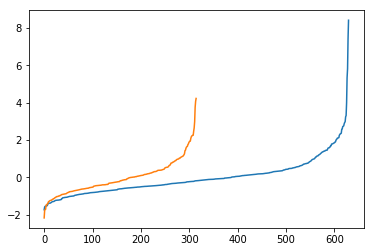

In [76]:
import matplotlib.pylab as plt
import numpy as np

plt.plot(np.sort(ytrain))
plt.plot(np.sort(ytest))
plt.show()

In [6]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms


In [77]:
def normalize(x, filter_percentile_more_than_percent=5, mu=[], std=[], bin_ix=[]):
    unobserved = (x == 0)*1.0
    if len(bin_ix) == 0:
        bin_ix = ( x.min(axis=0) == 0 ) & ( x.max(axis=0) == 1)
    xcop = x * 1.0
    xcop[xcop==0] = np.nan
    if len(mu) == 0:
        mu = np.nanmean(xcop, axis=0)
        mu[bin_ix] = 0.0
        mu[np.isnan(mu)] = 0.0
    if len(std) == 0:
        std = np.nanstd(xcop, axis=0)
        std[std==0]=1.0
        std[bin_ix]=1.0
        std[np.isnan(std)]=1.0

    normed_x = (x != 0) * ((x - mu)/ std*1.0)
    normed_x[abs(normed_x)>filter_percentile_more_than_percent] = 0
    return normed_x, mu, std, bin_ix, unobserved



In [78]:
class Autoencoder(nn.Module):
    '''simplest auto-encoder ever'''
    def __init__(self, inputdim, hiddendim):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(inputdim, hiddendim)
        self.fc2 = nn.Linear(hiddendim, inputdim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class AutoencoderConinBinar(nn.Module):
    '''simplest auto-encoder ever'''
    def __init__(self, inputdimbin, inputdimcont, hiddendim):
        super(AutoencoderConinBinar, self).__init__()
        print('autoencoder with:', inputdimbin, ' binary features and ', inputdimcont, ' continuous features')
        self.fc1 = nn.Linear(inputdimbin+inputdimcont, hiddendim)
        self.fcBin = nn.Linear(hiddendim, inputdimbin)
        self.fcCont = nn.Linear(hiddendim, inputdimcont)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x1, x2 = self.sigmoid(self.fcBin(x)), self.fcCont(x)
        return x1, x2
    

In [79]:
xtrainNorm, mu, sg, bin_ix, unobserved = normalize(xtrain)
xtestNorm, mutest, sgtest, bin_ix_test, unobserved_test = normalize(xtest, mu=mu, std=sg, bin_ix=bin_ix)

cont_ix = (np.array(bin_ix) == False)
xtrain_bin = xtrain[:,bin_ix]

xtrainNorm_cont = xtrainNorm[:,cont_ix]
xtrainNorm_bin = xtrainNorm[:,bin_ix]
unobserved_bin = unobserved[:, bin_ix]
unobserved_cont = unobserved[:,cont_ix]

xtestNorm_cont = xtestNorm[:,cont_ix]
xtestNorm_bin = xtestNorm[:,bin_ix]
unobservedtest_bin = unobserved_test[:, bin_ix]
unobservedtest_cont = unobserved_test[:,cont_ix]

print(xtrainNorm.shape, xtestNorm.shape, xtestNorm_bin.shape, xtestNorm_cont.shape)

(630, 494) (315, 494) (315, 402) (315, 92)


/Users/Narges/anaconda2/envs/3point5/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/Narges/anaconda2/envs/3point5/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


autoencoder with: 402  binary features and  92  continuous features


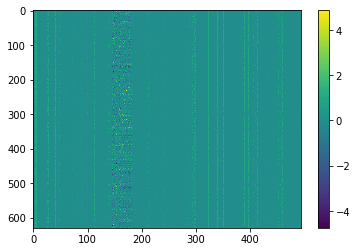

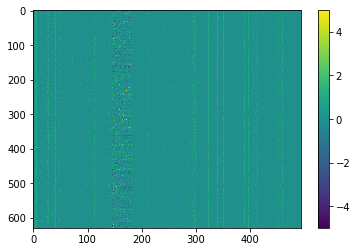

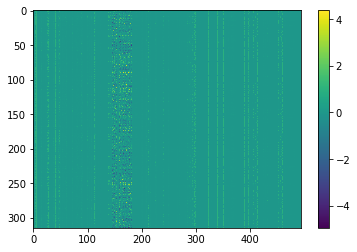

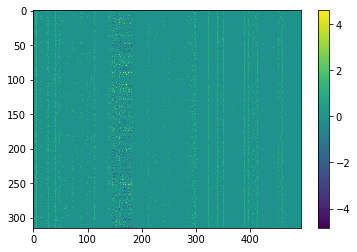

In [80]:
auto2 = AutoencoderConinBinar(xtrainNorm_bin.shape[1], xtrainNorm_cont.shape[1], 100)
optimizer = optim.SGD(auto2.parameters(), lr=0.5)
np.random.seed(0)
lossfuncBin = nn.BCELoss()
lossfunccont = nn.MSELoss()
for epoch in range(1, 200):
    auto2.train()
    for ix in range(len(xtrainNorm_bin)):
        databin = Variable(torch.from_numpy(xtrainNorm_bin[ix]).float())
        datacont = Variable(torch.from_numpy(xtrainNorm_cont[ix]).float())
        databoth = Variable(torch.from_numpy(np.hstack([xtrainNorm_bin[ix], xtrainNorm_cont[ix]]))).float()
        optimizer.zero_grad()
        xtrainoutBin, xtrainoutCont = auto2(databoth)
        loss = lossfuncBin(xtrainoutBin, databin) + lossfunccont(xtrainoutCont, datacont)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
        
auto2.eval()
xtrainout = np.zeros(xtrainNorm.shape)
for ix in range(len(xtrainNorm_bin)):
    databoth = Variable(torch.from_numpy(np.hstack([xtrainNorm_bin[ix], xtrainNorm_cont[ix]]))).float()
    outbin, outcont = auto2(databoth)
    xtrainout[ix,bin_ix] = outbin.data.numpy()
    xtrainout[ix,cont_ix] = outcont.data.numpy()

xtestout = np.zeros(xtestNorm.shape)
for ix in range(len(xtestNorm_bin)):
    databoth = Variable(torch.from_numpy(np.hstack([xtestNorm_bin[ix], xtestNorm_cont[ix]]))).float()
    outbin, outcont = auto2(databoth)
    xtestout[ix,bin_ix] = outbin.data.numpy()
    xtestout[ix,cont_ix] = outcont.data.numpy()

plt.imshow(xtrainout, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()
plt.imshow(xtrainNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()


plt.imshow(xtestout, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()
plt.imshow(xtestNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()

In [84]:
pickle.dump(file=open('girls24_autoencoded.pkl', 'wb'), obj=(xtrainout, xtestout, ytrain, ytrainlabel, ytest, ytestlabel, feature_headers), protocol=-1)

In [87]:
import train
print

In [110]:
out = train.train_regression(xtrain, ytrain, ytrainlabel, False, 'lasso', feature_headers, mrnstrain)
weights = out[0].coef_
sorted_ix = np.argsort(-1 * abs(weights))
print(weights.shape)
print(len(feature_headers))
for ix in sorted_ix:
    print (feature_headers[ix], weights[ix])
    if weights[ix] == 0:
        break

CV R^2 for alpha: 0.001 is: -0.133171877358
CV R^2 for alpha: 0.005 is: 0.134860345203
CV R^2 for alpha: 0.01 is: 0.179531641521
CV R^2 for alpha: 0.1 is: 0.203349509928
best alpha via CV: 0.1
AUC train: 0.760 Explained Variance Score Train: 0.235
AUC test: 0.735 Explained Variance Score Test: 0.203
(494,)
494
Vital: Wt for Len Percentile-avg13to16 0.18273367194
Vital: BMI-avg10to13 0.163031797002
Vital: Wt for Len Percentile-avg16to19 0.0991073052831
Diagnosis:9ccs0:No DX -0.0


In [111]:
out = train.train_regression(xtrainNorm, ytrain, ytrainlabel, False, 'lasso', feature_headers, mrnstrain)
weights = out[0].coef_
sorted_ix = np.argsort(-1 * abs(weights))
print(weights.shape)
print(len(feature_headers))
for ix in sorted_ix:
    print (feature_headers[ix], weights[ix])
    if weights[ix] == 0:
        break

CV R^2 for alpha: 0.001 is: -0.112209465707
CV R^2 for alpha: 0.005 is: 0.130712450835
CV R^2 for alpha: 0.01 is: 0.180106260595
CV R^2 for alpha: 0.1 is: 0.204682954971
best alpha via CV: 0.1
AUC train: 0.760 Explained Variance Score Train: 0.235
AUC test: 0.736 Explained Variance Score Test: 0.205
(494,)
494
Vital: Wt for Len Percentile-avg13to16 0.178811885914
Vital: BMI-avg10to13 0.160617104815
Vital: Wt for Len Percentile-avg16to19 0.101987647441
Diagnosis:9ccs0:No DX -0.0


In [112]:
out = train.train_regression(xtrainout, ytrain, ytrainlabel, False, 'lasso', feature_headers, mrnstrain)
weights = out[0].coef_
sorted_ix = np.argsort(-1 * abs(weights))
print(weights.shape)
print(len(feature_headers))
for ix in sorted_ix:
    print (feature_headers[ix], weights[ix])
    if weights[ix] == 0:
        break

CV R^2 for alpha: 0.001 is: 0.0305447939419
CV R^2 for alpha: 0.005 is: 0.174904915163
CV R^2 for alpha: 0.01 is: 0.210580206052
CV R^2 for alpha: 0.1 is: 0.203438214378
best alpha via CV: 0.01
AUC train: 0.823 Explained Variance Score Train: 0.356
AUC test: 0.734 Explained Variance Score Test: 0.211
(494,)
494
Maternal Diagnosis:9ccs186:DM in preg 0.577088133878
Diagnosis:9ccs58:Ot nutrit dx 0.563418206418
Newborn Diagnosis:9ccs224:Ot perint dx 0.279594466774
Vital: BMI-avg10to13 0.226375756816
Vital: Wt for Len Percentile-avg13to16 0.217718006281
Maternal-nationality:EL SALVADORAN 0.165529712364
Maternal Diagnosis:9ccs10:Immuniz/scrn 0.120350445103
Vital: Wt for Len Percentile-avg16to19 0.113813013785
Newborn Diagnosis:9ccs222:Perint jaund 0.110202034274
Vital: Ht-latest 0.0883867662006
Vital: HC-avg5to7 -0.0819214609607
Vital: Ht-avg16to19 -0.0722571259536
Vital: Wt Change-latest 0.0714738498959
Vital: HR-avg10to13 0.0664894196614
Diagnosis:9ccs126:Ot up rsp in 0.0613738394187
Vital

In [85]:
''' Autoencoder with mask for binary and continuous input'''
automask2 = AutoencoderConinBinar(xtrainNorm_bin.shape[1], xtrainNorm_cont.shape[1], 100)
optimizer = optim.SGD(auto2.parameters(), lr=0.5)
np.random.seed(0)
lossfuncBin = nn.BCELoss()
lossfunccont = nn.MSELoss()
for epoch in range(1, 200):
    auto2.train()
    for ix in range(len(xtrainNorm_bin)):
        databin = Variable(torch.from_numpy(xtrainNorm_bin[ix]).float())
        datacont = Variable(torch.from_numpy(xtrainNorm_cont[ix]).float())
        
        databoth = Variable(torch.from_numpy(np.hstack([xtrainNorm_bin[ix], xtrainNorm_cont[ix]]))).float()
        mask_input = (np.random.randn(xtrainNorm.shape[1])>0) * 1.0
        databoth_masked = Variable(torch.from_numpy(np.hstack([xtrainNorm_bin[ix], xtrainNorm_cont[ix]]) * mask_input).float())
        
        optimizer.zero_grad()
        xtrainoutBin, xtrainoutCont = auto2(databoth_masked)
        loss = lossfuncBin(xtrainoutBin, databin) + lossfunccont(xtrainoutCont, datacont)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
        
auto2.eval()
xtrainout = np.zeros(xtrainNorm.shape)
for ix in range(len(xtrainNorm_bin)):
    databoth = Variable(torch.from_numpy(np.hstack([xtrainNorm_bin[ix], xtrainNorm_cont[ix]]))).float()
    outbin, outcont = auto2(databoth)
    xtrainout[ix,bin_ix] = outbin.data.numpy()
    xtrainout[ix,cont_ix] = outcont.data.numpy()

xtestout = np.zeros(xtestNorm.shape)
for ix in range(len(xtestNorm_bin)):
    databoth = Variable(torch.from_numpy(np.hstack([xtestNorm_bin[ix], xtestNorm_cont[ix]]))).float()
    outbin, outcont = auto2(databoth)
    xtestout[ix,bin_ix] = outbin.data.numpy()
    xtestout[ix,cont_ix] = outcont.data.numpy()

plt.imshow(xtrainout, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()
plt.imshow(xtrainNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()


plt.imshow(xtestout, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()
plt.imshow(xtestNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()

autoencoder with: 402  binary features and  92  continuous features


KeyboardInterrupt: 

In [ ]:
xtestout

In [ ]:
bmi_avg = [(h == 'Vital: BMI-avg10to13') or (h == 'Vital: HC-avg10to13') for h in feature_headers]
[(xtestNorm[i,bmi_avg], xtestout[i,bmi_avg]) for i in range(len(xtestNorm))]

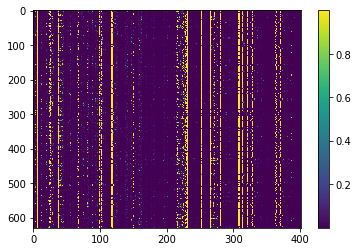

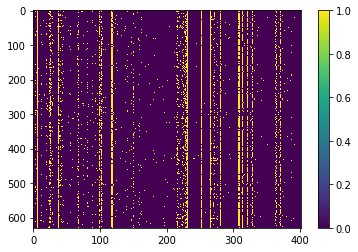

In [12]:
''' Basic analysis no mask, just an autoencoder '''
auto1 = Autoencoder(xtrain_bin.shape[1], 500)
optimizer = optim.SGD(auto1.parameters(), lr=0.5)
np.random.seed(0)
lossfunc = nn.BCELoss() #or MSELoss()

for epoch in range(1, 200):
    loss_list = []
    auto1.train()
    for ix, data in enumerate(xtrainNorm):
        datavar = Variable(torch.from_numpy(data).float())
        optimizer.zero_grad()
        xtrainout = auto1(datavar)
        loss = lossfunc(xtrainout, datavar)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()

auto1.eval()
xtrainout = np.zeros(xtrainNorm.shape)
for ix, data in enumerate(xtrainNorm):
    datavar = Variable(torch.from_numpy(data).float())
    out = auto1(datavar)
    xtrainout[ix,:] = out.data.numpy()
    
plt.imshow(xtrainout, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()
plt.imshow(xtrainNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()


In [ ]:
''' Adding mask so if some data is 0 from beginning we don't try to predict it, 
    but we purpusfully mask some of the input (at random) and require the encoder to predict those.'''
auto1 = Autoencoder(xtrain_bin.shape[1], 500)
optimizer = optim.SGD(auto1.parameters(), lr=0.5)
np.random.seed(0)
lossfunc = nn.BCELoss() #or MSELoss()

for epoch in range(1, 200):
    loss_list = []
    auto1.train()
    for ix, data in enumerate(xtrainNorm):
        mask_input = (np.random.randn(data.shape[0])>0) * 1.0
        datavar = Variable(torch.from_numpy(data).float())
        datavar_masked = Variable(torch.from_numpy(data * mask_input).float())
        # datavarmask = Variable(torch.from_numpy(mask))        
        optimizer.zero_grad()
        xtrainout = auto1(datavar_masked)
        loss = lossfunc(xtrainout, datavar)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        auto1.eval()
        xtrainout = np.zeros(xtrainNorm.shape)
        for ix, data in enumerate(xtrainNorm):
            datavar = Variable(torch.from_numpy(data).float())
            out = auto1(datavar)
            xtrainout[ix,:] = out.data.numpy()    
        plt.imshow(xtrainout, aspect='auto', interpolation='nearest'); plt.colorbar()
        plt.show()
        plt.imshow(xtrainNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
        plt.show()

        
auto1.eval()
xtrainout = np.zeros(xtrainNorm.shape)
for ix, data in enumerate(xtrainNorm):
    datavar = Variable(torch.from_numpy(data).float())
    out = auto1(datavar)
    xtrainout[ix,:] = out.data.numpy()
    
plt.imshow(xtrainout, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()
plt.imshow(xtrainNorm, aspect='auto', interpolation='nearest'); plt.colorbar()
plt.show()


In [ ]:
feature_headers_bin = np.array(feature_headers)[bin_ix]

In [ ]:
ox_ix = [h== 'Diagnosis:9ccs58:Ot nutrit dx' for h in feature_headers_bin]
sum(ox_ix)

In [ ]:
from sklearn import metrics
for ox_ix in range(len(feature_headers_bin)):
    [(xtrain_bin[i,ox_ix], xtrainout[i,ox_ix]) for i in range(0,len(xtrain_bin))]
    metrics.